### CLAPS (Test Data)

In [2]:
# model_output_dir = '/work/b0990106x/trl/model_output/1123-0014'
# model_output_dir = '/work/b0990106x/trl/model_output/1123-1002'
# model_output_dir = '/work/b0990106x/trl/model_output/1123-1644'
# model_output_dir = '/work/b0990106x/trl/model_output/1123-2127'
# model_output_dir = '/work/b0990106x/trl/model_output/1123-2321'
# model_output_dir = '/work/b0990106x/trl/model_output/1124-1014'
# model_output_dir = '/work/b0990106x/trl/model_output/1124-1502'
# model_output_dir = '/work/b0990106x/trl/model_output/1125-1318'
model_output_dir = '/work/b0990106x/trl/model_output/1125-1444'

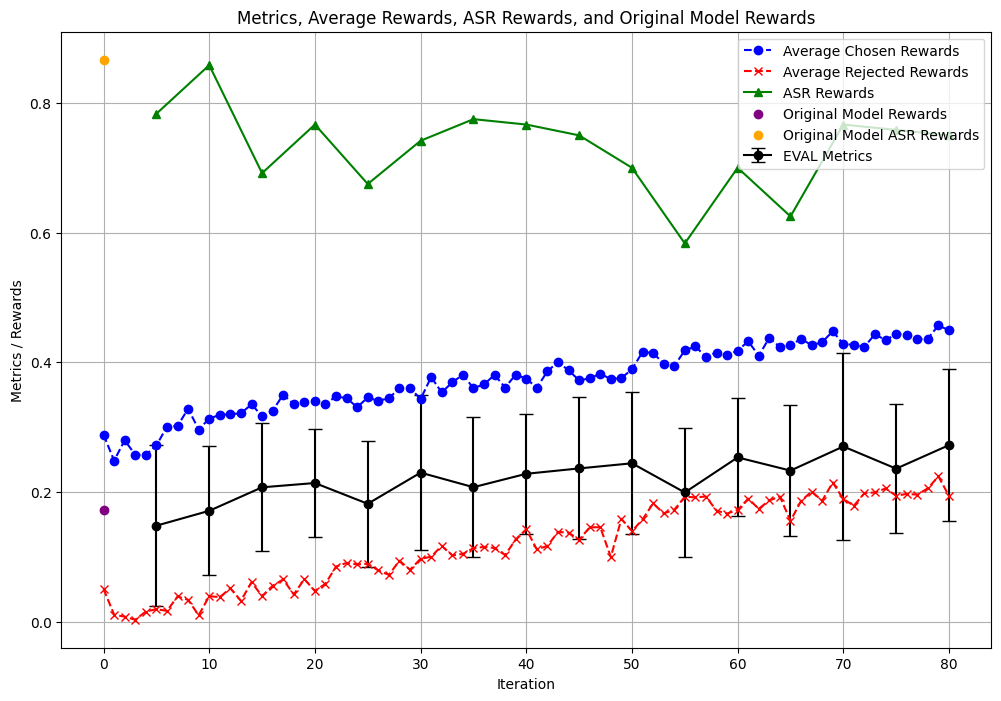

In [3]:
import re
import matplotlib.pyplot as plt
import ast
import numpy as np


log_path = f'{model_output_dir}/log_training.log'

def pooled_std_dev(std_devs, counts):
    """Calculate the pooled standard deviation."""
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))

    if denominator > 0:
        pooled_variance = numerator / denominator
        return np.sqrt(pooled_variance)
    else:
        return 0  # In case of single value or no variance


def parse_log_file(log_path):
    """Parse log file to extract evaluation metrics."""
    eval_pattern = re.compile(
        r"EVAL: Cosine_Sim metrics Test Set for iteration (\d+): (.+)"
    )
    original_model_pattern = re.compile(
        r"Original model metrics on Test set: (.+)"
    )

    data = {"EVAL": {}, "Original": []}

    def clean_and_convert(metrics_string):
        """Clean and safely convert a metrics string to a Python object."""
        metrics_string = (
            metrics_string.replace("np.float64", "")
            .replace("(", "")
            .replace(")", "")
            .replace("'", '"')  # Ensure JSON compatibility
        )
        try:
            return ast.literal_eval(metrics_string)
        except Exception as e:
            print(f"Failed to parse metrics string: {metrics_string}\nError: {e}")
            return []

    with open(log_path, 'r') as log_file:
        for line in log_file:
            eval_match = eval_pattern.search(line)
            original_match = original_model_pattern.search(line)

            if eval_match:
                iteration = int(eval_match.group(1)) + 1  # Shift iteration index
                metrics_list = eval_match.group(2).strip()

                metrics_list = clean_and_convert(metrics_list)
                if not metrics_list:
                    print(f"Skipping invalid EVAL data for iteration {iteration}.")
                    continue

                means, std_devs, counts = [], [], []

                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        count = len(metrics['metrics']['rewards'])
                        means.append(mean)
                        std_devs.append(std_dev)
                        counts.append(count)
                    except KeyError:
                        print(f"Skipping malformed metrics: {metrics}")
                        continue

                data["EVAL"][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts
                }

            elif original_match:
                metrics_list = original_match.group(1).strip()

                metrics_list = clean_and_convert(metrics_list)
                if not metrics_list:
                    print("Skipping invalid Original model data.")
                    continue

                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        data["Original"].append((mean, std_dev))
                    except KeyError:
                        print(f"Skipping malformed Original metrics: {metrics}")
                        continue

    return data


def parse_chosen_rejected_rewards(log_path):
    """Parse the log file to extract chosen and rejected rewards."""
    chosen_pattern = re.compile(r"Chosen rewards for iteration (\d+): (.+)")
    rejected_pattern = re.compile(r"Rejected rewards for iteration (\d+): (.+)")

    chosen_rewards = {}
    rejected_rewards = {}

    def parse_rewards(rewards_string):
        """Parse and convert a rewards string to a list of floats."""
        rewards_string = rewards_string.strip()
        try:
            return ast.literal_eval(rewards_string)
        except Exception as e:
            print(f"Failed to parse rewards: {rewards_string}\nError: {e}")
            return []

    with open(log_path, 'r') as log_file:
        for line in log_file:
            chosen_match = chosen_pattern.search(line)
            rejected_match = rejected_pattern.search(line)

            if chosen_match:
                iteration = int(chosen_match.group(1))
                rewards = parse_rewards(chosen_match.group(2))
                if rewards:
                    chosen_rewards[iteration] = rewards

            if rejected_match:
                iteration = int(rejected_match.group(1))
                rewards = parse_rewards(rejected_match.group(2))
                if rewards:
                    rejected_rewards[iteration] = rewards

    return chosen_rewards, rejected_rewards


def parse_asr_rewards(log_path):
    """Parse the log file to extract ASR rewards."""
    asr_pattern = re.compile(r"EVAL: Trained model average ASR rewards on Test set: (\d+\.\d+)")
    asr_rewards = {}

    current_iteration = None

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if "Starting iteration" in line:
                # Extract the iteration number
                current_iteration = int(re.search(r"iteration (\d+)", line).group(1)) + 1
            asr_match = asr_pattern.search(line)
            if asr_match and current_iteration is not None:
                # Store the ASR reward for the current iteration
                asr_rewards[current_iteration] = float(asr_match.group(1))

    return asr_rewards


def parse_original_model_rewards(log_path):
    """Parse the log file to extract Original Model rewards and ASR rewards."""
    original_pattern = re.compile(r"Original model average rewards on Test set: (\d+\.\d+)")
    asr_pattern = re.compile(r"Original model average ASR rewards on Test set: (\d+\.\d+)")

    original_rewards = None
    original_asr_rewards = None

    with open(log_path, 'r') as log_file:
        for line in log_file:
            original_match = original_pattern.search(line)
            asr_match = asr_pattern.search(line)

            if original_match:
                original_rewards = float(original_match.group(1))
            if asr_match:
                original_asr_rewards = float(asr_match.group(1))

    return original_rewards, original_asr_rewards


def plot_all_metrics_with_asr_and_original(data, chosen_rewards, rejected_rewards, asr_rewards, original_rewards, original_asr_rewards):
    """Plot all metrics on the same figure, including ASR and Original Model rewards."""
    plt.figure(figsize=(12, 8))

    # Plot EVAL Metrics
    iterations = sorted(data["EVAL"].keys())
    avg_means, pooled_std_devs = [], []

    for iteration in iterations:
        means = data["EVAL"][iteration]["means"]
        std_devs = data["EVAL"][iteration]["std_devs"]
        counts = data["EVAL"][iteration]["counts"]

        avg_mean = np.mean(means)
        avg_means.append(avg_mean)

        pooled_std_dev_value = pooled_std_dev(std_devs, counts)
        pooled_std_devs.append(pooled_std_dev_value)

    if iterations:
        plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label='EVAL Metrics', color='black')

    # Plot chosen and rejected rewards
    all_iterations = sorted(set(chosen_rewards.keys()).union(rejected_rewards.keys()))
    avg_chosen = [np.mean(chosen_rewards.get(it, [])) for it in all_iterations]
    avg_rejected = [np.mean(rejected_rewards.get(it, [])) for it in all_iterations]

    plt.plot(all_iterations, avg_chosen, marker='o', linestyle='--', label='Average Chosen Rewards', color='blue')
    plt.plot(all_iterations, avg_rejected, marker='x', linestyle='--', label='Average Rejected Rewards', color='red')

    # Plot ASR rewards
    asr_iterations = sorted(asr_rewards.keys())
    asr_values = [asr_rewards[it] for it in asr_iterations]
    plt.plot(asr_iterations, asr_values, marker='^', linestyle='-', label='ASR Rewards', color='green')

    # Plot Original Model rewards and ASR
    if original_rewards is not None:
        plt.scatter([0], [original_rewards], color='purple', label='Original Model Rewards', zorder=5)
    if original_asr_rewards is not None:
        plt.scatter([0], [original_asr_rewards], color='orange', label='Original Model ASR Rewards', zorder=5)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Metrics / Rewards')
    plt.title('Metrics, Average Rewards, ASR Rewards, and Original Model Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()


# Parse the log file
data = parse_log_file(log_path)
chosen_rewards, rejected_rewards = parse_chosen_rejected_rewards(log_path)
asr_rewards = parse_asr_rewards(log_path)
original_rewards, original_asr_rewards = parse_original_model_rewards(log_path)

# Plot all metrics together with ASR rewards and Original Model rewards
plot_all_metrics_with_asr_and_original(data, chosen_rewards, rejected_rewards, asr_rewards, original_rewards, original_asr_rewards)


### CLAPS (Train Data)

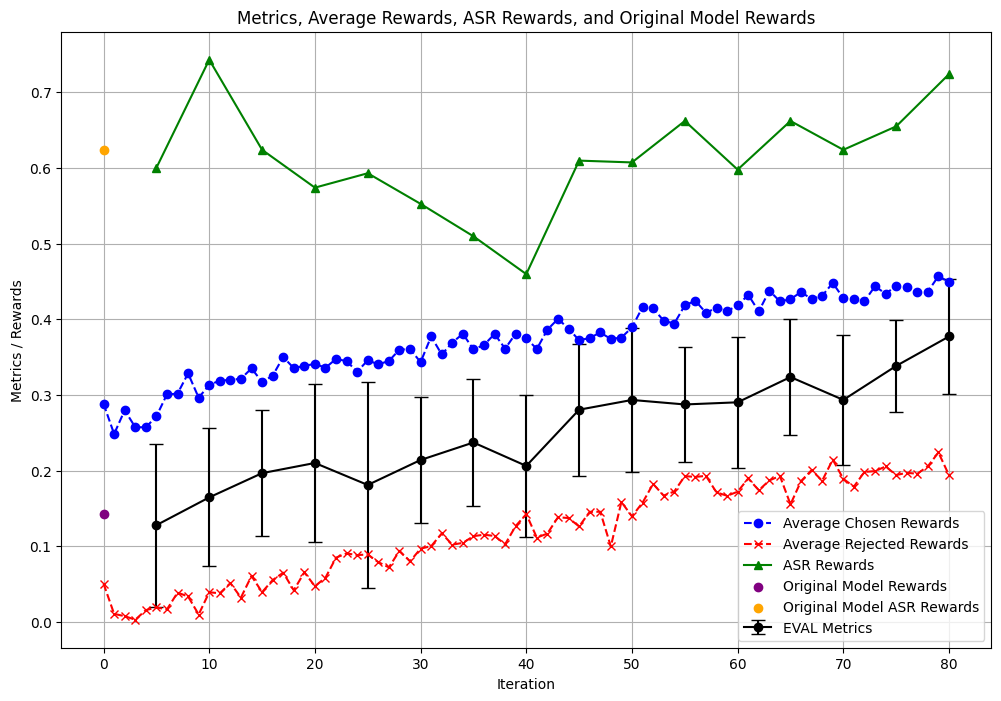

In [4]:
import re
import matplotlib.pyplot as plt
import ast
import numpy as np


log_path = f'{model_output_dir}/log_training.log'

def pooled_std_dev(std_devs, counts):
    """Calculate the pooled standard deviation."""
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))

    if denominator > 0:
        pooled_variance = numerator / denominator
        return np.sqrt(pooled_variance)
    else:
        return 0  # In case of single value or no variance


def parse_log_file(log_path):
    """Parse log file to extract evaluation metrics."""
    eval_pattern = re.compile(
        r"EVAL: Cosine_Sim metrics Train Set for iteration (\d+): (.+)"
    )
    original_model_pattern = re.compile(
        r"Original model metrics on Train set: (.+)"
    )

    data = {"EVAL": {}, "Original": []}

    def clean_and_convert(metrics_string):
        """Clean and safely convert a metrics string to a Python object."""
        metrics_string = (
            metrics_string.replace("np.float64", "")
            .replace("(", "")
            .replace(")", "")
            .replace("'", '"')  # Ensure JSON compatibility
        )
        try:
            return ast.literal_eval(metrics_string)
        except Exception as e:
            print(f"Failed to parse metrics string: {metrics_string}\nError: {e}")
            return []

    with open(log_path, 'r') as log_file:
        for line in log_file:
            eval_match = eval_pattern.search(line)
            original_match = original_model_pattern.search(line)

            if eval_match:
                iteration = int(eval_match.group(1)) + 1  # Shift iteration index
                metrics_list = eval_match.group(2).strip()

                metrics_list = clean_and_convert(metrics_list)
                if not metrics_list:
                    print(f"Skipping invalid EVAL data for iteration {iteration}.")
                    continue

                means, std_devs, counts = [], [], []

                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        count = len(metrics['metrics']['rewards'])
                        means.append(mean)
                        std_devs.append(std_dev)
                        counts.append(count)
                    except KeyError:
                        print(f"Skipping malformed metrics: {metrics}")
                        continue

                data["EVAL"][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts
                }

            elif original_match:
                metrics_list = original_match.group(1).strip()

                metrics_list = clean_and_convert(metrics_list)
                if not metrics_list:
                    print("Skipping invalid Original model data.")
                    continue

                for metrics in metrics_list:
                    try:
                        mean = metrics['metrics']['mean']
                        std_dev = metrics['metrics']['std_dev']
                        data["Original"].append((mean, std_dev))
                    except KeyError:
                        print(f"Skipping malformed Original metrics: {metrics}")
                        continue

    return data


def parse_chosen_rejected_rewards(log_path):
    """Parse the log file to extract chosen and rejected rewards."""
    chosen_pattern = re.compile(r"Chosen rewards for iteration (\d+): (.+)")
    rejected_pattern = re.compile(r"Rejected rewards for iteration (\d+): (.+)")

    chosen_rewards = {}
    rejected_rewards = {}

    def parse_rewards(rewards_string):
        """Parse and convert a rewards string to a list of floats."""
        rewards_string = rewards_string.strip()
        try:
            return ast.literal_eval(rewards_string)
        except Exception as e:
            print(f"Failed to parse rewards: {rewards_string}\nError: {e}")
            return []

    with open(log_path, 'r') as log_file:
        for line in log_file:
            chosen_match = chosen_pattern.search(line)
            rejected_match = rejected_pattern.search(line)

            if chosen_match:
                iteration = int(chosen_match.group(1))
                rewards = parse_rewards(chosen_match.group(2))
                if rewards:
                    chosen_rewards[iteration] = rewards

            if rejected_match:
                iteration = int(rejected_match.group(1))
                rewards = parse_rewards(rejected_match.group(2))
                if rewards:
                    rejected_rewards[iteration] = rewards

    return chosen_rewards, rejected_rewards


def parse_asr_rewards(log_path):
    """Parse the log file to extract ASR rewards."""
    asr_pattern = re.compile(r"EVAL: Trained model average ASR rewards on Train set: (\d+\.\d+)")
    asr_rewards = {}

    current_iteration = None

    with open(log_path, 'r') as log_file:
        for line in log_file:
            if "Starting iteration" in line:
                # Extract the iteration number
                current_iteration = int(re.search(r"iteration (\d+)", line).group(1)) + 1
            asr_match = asr_pattern.search(line)
            if asr_match and current_iteration is not None:
                # Store the ASR reward for the current iteration
                asr_rewards[current_iteration] = float(asr_match.group(1))

    return asr_rewards


def parse_original_model_rewards(log_path):
    """Parse the log file to extract Original Model rewards and ASR rewards."""
    original_pattern = re.compile(r"Original model average rewards on Train set: (\d+\.\d+)")
    asr_pattern = re.compile(r"Original model average ASR rewards on Train set: (\d+\.\d+)")

    original_rewards = None
    original_asr_rewards = None

    with open(log_path, 'r') as log_file:
        for line in log_file:
            original_match = original_pattern.search(line)
            asr_match = asr_pattern.search(line)

            if original_match:
                original_rewards = float(original_match.group(1))
            if asr_match:
                original_asr_rewards = float(asr_match.group(1))

    return original_rewards, original_asr_rewards


def plot_all_metrics_with_asr_and_original(data, chosen_rewards, rejected_rewards, asr_rewards, original_rewards, original_asr_rewards):
    """Plot all metrics on the same figure, including ASR and Original Model rewards."""
    plt.figure(figsize=(12, 8))

    # Plot EVAL Metrics
    iterations = sorted(data["EVAL"].keys())
    avg_means, pooled_std_devs = [], []

    for iteration in iterations:
        means = data["EVAL"][iteration]["means"]
        std_devs = data["EVAL"][iteration]["std_devs"]
        counts = data["EVAL"][iteration]["counts"]

        avg_mean = np.mean(means)
        avg_means.append(avg_mean)

        pooled_std_dev_value = pooled_std_dev(std_devs, counts)
        pooled_std_devs.append(pooled_std_dev_value)

    if iterations:
        plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label='EVAL Metrics', color='black')

    # Plot chosen and rejected rewards
    all_iterations = sorted(set(chosen_rewards.keys()).union(rejected_rewards.keys()))
    avg_chosen = [np.mean(chosen_rewards.get(it, [])) for it in all_iterations]
    avg_rejected = [np.mean(rejected_rewards.get(it, [])) for it in all_iterations]

    plt.plot(all_iterations, avg_chosen, marker='o', linestyle='--', label='Average Chosen Rewards', color='blue')
    plt.plot(all_iterations, avg_rejected, marker='x', linestyle='--', label='Average Rejected Rewards', color='red')

    # Plot ASR rewards
    asr_iterations = sorted(asr_rewards.keys())
    asr_values = [asr_rewards[it] for it in asr_iterations]
    plt.plot(asr_iterations, asr_values, marker='^', linestyle='-', label='ASR Rewards', color='green')

    # Plot Original Model rewards and ASR
    if original_rewards is not None:
        plt.scatter([0], [original_rewards], color='purple', label='Original Model Rewards', zorder=5)
    if original_asr_rewards is not None:
        plt.scatter([0], [original_asr_rewards], color='orange', label='Original Model ASR Rewards', zorder=5)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Metrics / Rewards')
    plt.title('Metrics, Average Rewards, ASR Rewards, and Original Model Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()


# Parse the log file
data = parse_log_file(log_path)
chosen_rewards, rejected_rewards = parse_chosen_rejected_rewards(log_path)
asr_rewards = parse_asr_rewards(log_path)
original_rewards, original_asr_rewards = parse_original_model_rewards(log_path)

# Plot all metrics together with ASR rewards and Original Model rewards
plot_all_metrics_with_asr_and_original(data, chosen_rewards, rejected_rewards, asr_rewards, original_rewards, original_asr_rewards)


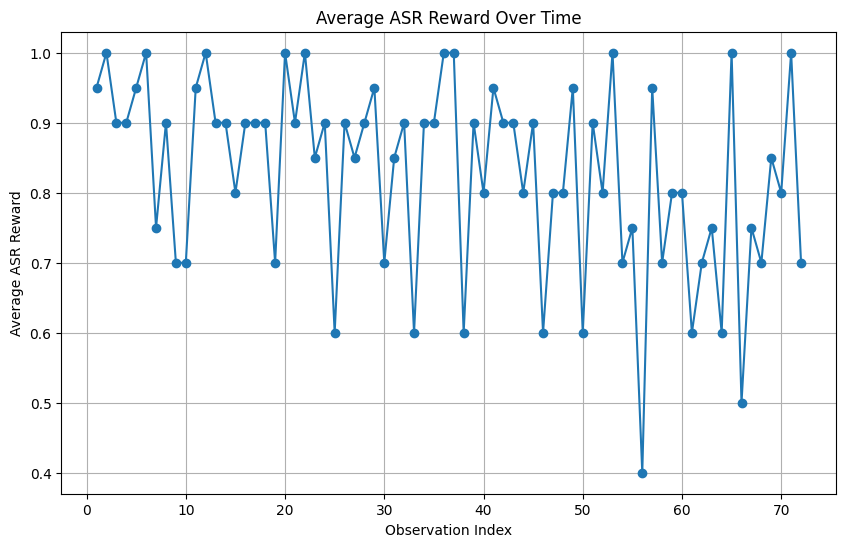

In [6]:
import re
import matplotlib.pyplot as plt

log_path = '11241014.log'

rewards = []

pattern = r"average asr reward: ([0-9]*\.?[0-9]+)"
with open(log_path, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            rewards.append(float(match.group(1)))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rewards) + 1), rewards, marker='o')
plt.title('Average ASR Reward Over Time')
plt.xlabel('Observation Index')
plt.ylabel('Average ASR Reward')
plt.grid(True)
plt.show()


### DPO Claps & MOS

In [ ]:
import re
import matplotlib.pyplot as plt

# Model output directory and log path
# model_output_dir = '/work/b0990106x/trl/model_output/1020-2012'
# model_output_dir = '/work/b0990106x/trl/model_output/1023-1238'
# model_output_dir = '/work/b0990106x/trl/model_output/1023-1716'
model_output_dir = '/work/b0990106x/trl/model_output/1023-1910'
log_path = f'{model_output_dir}/log_training.log'

# Initialize lists to store the parsed data
iterations = []
cosine_sim_scores = []
mos_scores = []
weighted_avg_scores = []
chosen_rewards_avg = []
rejected_rewards_avg = []
original_mos_score = 0
original_claps_score = 0
original_weighted_avg_score = 0

# Training
# original_mos_pattern = r"Original model average MOS on training set: ([\d.]+)"
# original_claps_pattern = r"Original model average Claps on training set: ([\d.]+)"
# original_weighted_pattern = r"Original model weighted average rewards on training set: ([\d.]+)"

# mos_pattern = r"MOS score on training set for iteration (\d+): ([\d.]+)"
# cosine_sim_pattern = r"Cosine_Sim score on training set for iteration (\d+): ([\d.]+)"
# weighted_avg_pattern = r"weighted average score on training set for iteration (\d+): ([\d.]+)"

# Testing
original_mos_pattern = r"Original Model Test average MOS: ([\d.]+)"
original_claps_pattern = r"Original Model Test average Claps: ([\d.]+)"
original_weighted_pattern = r"Original Model Test weighted average rewards: ([\d.]+)"

mos_pattern = r"MOS score on Testing set for iteration (\d+): ([\d.]+)"
cosine_sim_pattern = r"Cosine_Sim score on Testing set for iteration (\d+): ([\d.]+)"
weighted_avg_pattern = r"weighted average score on Testing set for iteration (\d+): ([\d.]+)"

chosen_pattern = r"Chosen rewards for iteration \d+: \[([\d., ]+)\]"
rejected_pattern = r"Rejected rewards for iteration \d+: \[([\d\.,\s-]+)\]"

# Open the log file for reading
with open(log_path, 'r') as log_file:
    for line in log_file:
        # Check if the line matches the Cosine_Sim score
        cosine_sim_match = re.search(cosine_sim_pattern, line)
        if cosine_sim_match:
            iteration = int(cosine_sim_match.group(1)) + 1
            cosine_sim_score = float(cosine_sim_match.group(2))
            iterations.append(iteration)
            cosine_sim_scores.append(cosine_sim_score)
        
        # Check if the line matches the MOS score
        mos_match = re.search(mos_pattern, line)
        if mos_match:
            mos_score = float(mos_match.group(2)) / 5  # Normalize MOS score
            mos_scores.append(mos_score)

        # Check if the line matches the weighted average score
        weighted_avg_match = re.search(weighted_avg_pattern, line)
        if weighted_avg_match:
            weighted_avg_score = float(weighted_avg_match.group(2))
            weighted_avg_scores.append(weighted_avg_score)

        # Check if the line matches the original MOS score
        original_mos_match = re.search(original_mos_pattern, line)
        if original_mos_match:
            original_mos_score = float(original_mos_match.group(1)) / 5

        # Check if the line matches the original claps score
        original_claps_match = re.search(original_claps_pattern, line)
        if original_claps_match:
            original_claps_score = float(original_claps_match.group(1))

        # Check if the line matches the original weighted average score
        original_weighted_match = re.search(original_weighted_pattern, line)
        if original_weighted_match:
            original_weighted_avg_score = float(original_weighted_match.group(1))

        # Check if the line matches the chosen rewards
        chosen_match = re.search(chosen_pattern, line)
        if chosen_match:
            chosen_rewards_values = [float(x) for x in chosen_match.group(1).split(", ")]
            chosen_rewards_avg.append(sum(chosen_rewards_values) / len(chosen_rewards_values))  # Take average

        # Check if the line matches the rejected rewards
        rejected_match = re.search(rejected_pattern, line)
        if rejected_match:
            rejected_rewards_values = [float(x) for x in rejected_match.group(1).split(", ")]
            rejected_rewards_avg.append(sum(rejected_rewards_values) / len(rejected_rewards_values))  # Take average

# Plot the metrics
plt.figure(figsize=(10, 6))

# Plot with smaller marker sizes
plt.plot(iterations, weighted_avg_scores, label='Weighted Avg Score', marker='^', markersize=4)
plt.plot(iterations, cosine_sim_scores, label='Cosine_Sim Score', marker='o', markersize=4)
plt.plot(iterations, mos_scores, label='MOS Score', marker='s', markersize=4)

# Plot chosen and rejected rewards averages
if len(chosen_rewards_avg) > 0:
    plt.plot(iterations, chosen_rewards_avg, label='Chosen Rewards Avg', marker='D', linestyle='--', markersize=4)
if len(rejected_rewards_avg) > 0:
    plt.plot(iterations, rejected_rewards_avg, label='Rejected Rewards Avg', marker='x', linestyle=':', markersize=4)

# Plot the original scores as points
plt.plot([0], [original_mos_score], label='Original MOS Score', marker='x', markersize=8, color='red')
plt.plot([0], [original_claps_score], label='Original Claps Score', marker='o', markersize=8, color='green')
plt.plot([0], [original_weighted_avg_score], label='Original Weighted Avg Score', marker='^', markersize=8, color='blue')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics Over Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



### MOS only

In [ ]:
import re
import matplotlib.pyplot as plt

# Model output directory and log path
# model_output_dir = '/work/b0990106x/trl/model_output/1021-1054'
# model_output_dir = '/work/b0990106x/trl/model_output/1021-1454'
# model_output_dir = '/work/b0990106x/trl/model_output/1021-1607'
# model_output_dir = '/work/b0990106x/trl/model_output/1021-2059'
# model_output_dir = '/work/b0990106x/trl/model_output/1022-0016'
# model_output_dir = '/work/b0990106x/trl/model_output/1022-1223'
# model_output_dir = '/work/b0990106x/trl/model_output/1022-1339'
# model_output_dir = '/work/b0990106x/trl/model_output/1022-1913'
# model_output_dir = '/work/b0990106x/trl/model_output/1102-1403'
model_output_dir = '/work/b0990106x/trl/model_output/1102-1805'

log_path = f'{model_output_dir}/log_training.log'

# Initialize lists to store the parsed data
iterations = []
original_mos_score = 0
mos_scores = []
weighted_avg_scores = []
chosen_rewards_avg = []
rejected_rewards_avg = []

# Regular expression patterns to extract the relevant data
mos_pattern = r"MOS score on training set for iteration (\d+): ([\d.]+)"
original_mos_pattern = r"Original model weighted average rewards on training set: (\d.+)"
weighted_avg_pattern = r"weighted average score on training set for iteration (\d+): ([\d.]+)"
chosen_pattern = r"Chosen rewards for iteration \d+: \[([\d., ]+)\]"
rejected_pattern = r"Rejected rewards for iteration \d+: \[([\d., ]+)\]"

# Open the log file for reading
with open(log_path, 'r') as log_file:  # Replace with your log file path
    for line in log_file:
        
        # Check if the line matches the MOS score
        mos_match = re.search(mos_pattern, line)
        original_mos_match = re.search(original_mos_pattern, line)
        
        if mos_match:
            mos_score = float(mos_match.group(2)) / 5  # Normalize MOS score
            mos_scores.append(mos_score)
        
        if original_mos_match:
            original_mos_score = float(original_mos_match.group(1))
            
        # Check if the line matches the weighted average score
        weighted_avg_match = re.search(weighted_avg_pattern, line)
        if weighted_avg_match:
            weighted_avg_score = float(weighted_avg_match.group(2))
            weighted_avg_scores.append(weighted_avg_score)
        
        # Check if the line matches the chosen rewards
        chosen_match = re.search(chosen_pattern, line)
        if chosen_match:
            chosen_rewards_values = [float(x) for x in chosen_match.group(1).split(", ")]
            chosen_rewards_avg.append(sum(chosen_rewards_values) / len(chosen_rewards_values))  # Take average

        # Check if the line matches the rejected rewards
        rejected_match = re.search(rejected_pattern, line)
        if rejected_match:
            rejected_rewards_values = [float(x) for x in rejected_match.group(1).split(", ")]
            rejected_rewards_avg.append(sum(rejected_rewards_values) / len(rejected_rewards_values))  # Take average

# Ensure all lists have the same length and sorted by iteration
iterations = range(1, len(mos_scores) + 1)

# Plot the metrics
plt.figure(figsize=(10, 6))

# Plot MOS Score and weighted average score
plt.plot(iterations, weighted_avg_scores, label='Weighted Avg Score', marker='^', markersize=4)
plt.plot([0], [original_mos_score], label='Original MOS Score', marker='x', markersize=8)

# Plot average chosen and rejected rewards
if len(chosen_rewards_avg) > 0:
    plt.plot(iterations, chosen_rewards_avg, label='Avg Chosen Rewards', marker='o', linestyle='--', markersize=4)
if len(rejected_rewards_avg) > 0:
    plt.plot(iterations, rejected_rewards_avg, label='Avg Rejected Rewards', marker='s', linestyle=':', markersize=4)

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics Over Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



### UT MOS only

In [ ]:
import re
import matplotlib.pyplot as plt

# Model output directory and log path
# model_output_dir = '/work/b0990106x/trl/model_output/1102-1919'
# model_output_dir = '/work/b0990106x/trl/model_output/1103-0030'
# model_output_dir = '/work/b0990106x/trl/model_output/1103-0954'
# model_output_dir = '/work/b0990106x/trl/model_output/1103-1937'
# model_output_dir = '/work/b0990106x/trl/model_output/1103-2012'
# model_output_dir = '/work/b0990106x/trl/model_output/1104-0059'
# model_output_dir = '/work/b0990106x/trl/model_output/1104-1057'
# model_output_dir = '/work/b0990106x/trl/model_output/1111-1853'
# model_output_dir = '/work/b0990106x/trl/model_output/1111-2129'
# model_output_dir = '/work/b0990106x/trl/model_output/1112-0923'
# model_output_dir = '/work/b0990106x/trl/model_output/1112-1530'
# model_output_dir = '/work/b0990106x/trl/model_output/1112-1727'
model_output_dir = '/work/b0990106x/trl/model_output/1113-1019'
log_path = f'{model_output_dir}/log_training.log'

# Initialize lists to store the parsed data
original_mos_score = 0
mos_scores = []
weighted_avg_scores = []
chosen_rewards_avg = []
rejected_rewards_avg = []

# Regular expression patterns to extract the relevant data
mos_pattern = r"EVAL: MOS score Training Set for iteration (\d+): \[\[([\d., ]+)\]\]"
weighted_avg_pattern = r"EVAL: Trained model weighted average rewards on training set for iteration (\d+): ([\d.]+)"
original_mos_pattern = r"Original model weighted average rewards on training set: ([\d.]+)"
chosen_pattern = r"Chosen rewards for iteration \d+: \[([\d., ]+)\]"
rejected_pattern = r"Rejected rewards for iteration \d+: \[([\d., ]+)\]"

# Open the log file for reading
with open(log_path, 'r') as log_file:
    for line in log_file:
        # Check if the line matches the Original MOS score
        original_mos_match = re.search(original_mos_pattern, line)
        if original_mos_match:
            original_mos_score = float(original_mos_match.group(1))

        # Check if the line matches the MOS score
        mos_match = re.search(mos_pattern, line)
        if mos_match:
            iteration = int(mos_match.group(1))
            mos_score_list_str = mos_match.group(2)
            mos_score_values = [float(x.strip()) for x in mos_score_list_str.split(",")]
            mos_avg = sum(mos_score_values) / len(mos_score_values)
            mos_scores.append(mos_avg)

        # Check if the line matches the weighted average score
        weighted_avg_match = re.search(weighted_avg_pattern, line)
        if weighted_avg_match:
            iteration = int(weighted_avg_match.group(1))
            weighted_avg_score = float(weighted_avg_match.group(2))
            weighted_avg_scores.append(weighted_avg_score)

        # Check if the line matches the chosen rewards
        chosen_match = re.search(chosen_pattern, line)
        if chosen_match:
            chosen_rewards_values = [float(x.strip()) for x in chosen_match.group(1).split(",")]
            if chosen_rewards_values:
                chosen_avg = sum(chosen_rewards_values) / len(chosen_rewards_values)
                chosen_rewards_avg.append(chosen_avg)

        # Check if the line matches the rejected rewards
        rejected_match = re.search(rejected_pattern, line)
        if rejected_match:
            rejected_rewards_values = [float(x.strip()) for x in rejected_match.group(1).split(",")]
            if rejected_rewards_values:
                rejected_avg = sum(rejected_rewards_values) / len(rejected_rewards_values)
                rejected_rewards_avg.append(rejected_avg)

# Debugging: Print lengths of all lists
print(f"Original MOS Score: {original_mos_score}")
print(f"Total Iterations Parsed: {len(mos_scores)}")
print(f"MOS Scores (Average per Iteration): {mos_scores}")
print(f"Weighted Avg Scores: {weighted_avg_scores}")
print(f"Chosen Rewards Avg: {chosen_rewards_avg}")
print(f"Rejected Rewards Avg: {rejected_rewards_avg}")

# Define iterations based on the maximum length among all metrics
max_length = max(len(mos_scores), len(weighted_avg_scores), len(chosen_rewards_avg), len(rejected_rewards_avg))
iterations = range(1, max_length + 1)

# Plot the metrics
plt.figure(figsize=(12, 8))

# Plot MOS Score and weighted average score
if len(weighted_avg_scores) > 0:
    plt.plot(range(1, len(weighted_avg_scores) + 1), weighted_avg_scores, label='Weighted Avg Score', marker='^', markersize=6)
# if original_mos_score > 0:
#     plt.axhline(y=original_mos_score, color='r', linestyle='-', label='Original MOS Score')
plt.plot([0], [original_mos_score], label='Original MOS Score', marker='x', markersize=8)


# Plot average chosen and rejected rewards
if len(chosen_rewards_avg) > 0:
    plt.plot(range(1, len(chosen_rewards_avg) + 1), chosen_rewards_avg, label='Avg Chosen Rewards', marker='o', linestyle='--', markersize=6)
if len(rejected_rewards_avg) > 0:
    plt.plot(range(1, len(rejected_rewards_avg) + 1), rejected_rewards_avg, label='Avg Rejected Rewards', marker='s', linestyle=':', markersize=6)

# Add labels and title
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Model Evaluation Metrics Over Iterations', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


### ASR only

In [ ]:
import re
import matplotlib.pyplot as plt

# Model output directory and log path
model_output_dir = '/work/b0990106x/trl/model_output/1116-1243'
log_path = f'{model_output_dir}/log_training.log'

# Initialize lists to store the parsed data
original_mos_score = 0
mos_scores = []
weighted_avg_scores = []
chosen_rewards_avg = []
rejected_rewards_avg = []

# Regular expression patterns to extract the relevant data
mos_pattern = r"EVAL: ASR score Training Set for iteration (\d+): \[\[([\d., ]+)\]\]"
weighted_avg_pattern = r"EVAL: Trained model weighted average rewards on training set for iteration (\d+): ([\d.]+)"
original_mos_pattern = r"Original model weighted average rewards on training set: ([\d.]+)"
chosen_pattern = r"Chosen rewards for iteration \d+: \[([\d., ]+)\]"
rejected_pattern = r"Rejected rewards for iteration \d+: \[([\d., ]+)\]"

# Open the log file for reading
with open(log_path, 'r') as log_file:
    for line in log_file:
        # Check if the line matches the Original MOS score
        original_mos_match = re.search(original_mos_pattern, line)
        if original_mos_match:
            original_mos_score = float(original_mos_match.group(1))

        # Check if the line matches the MOS score
        mos_match = re.search(mos_pattern, line)
        if mos_match:
            iteration = int(mos_match.group(1))
            mos_score_list_str = mos_match.group(2)
            mos_score_values = [float(x.strip()) for x in mos_score_list_str.split(",")]
            mos_avg = sum(mos_score_values) / len(mos_score_values)
            mos_scores.append(mos_avg)

        # Check if the line matches the weighted average score
        weighted_avg_match = re.search(weighted_avg_pattern, line)
        if weighted_avg_match:
            iteration = int(weighted_avg_match.group(1))
            weighted_avg_score = float(weighted_avg_match.group(2))
            weighted_avg_scores.append(weighted_avg_score)

        # Check if the line matches the chosen rewards
        chosen_match = re.search(chosen_pattern, line)
        if chosen_match:
            chosen_rewards_values = [float(x.strip()) for x in chosen_match.group(1).split(",")]
            if chosen_rewards_values:
                chosen_avg = sum(chosen_rewards_values) / len(chosen_rewards_values)
                chosen_rewards_avg.append(chosen_avg)

        # Check if the line matches the rejected rewards
        rejected_match = re.search(rejected_pattern, line)
        if rejected_match:
            rejected_rewards_values = [float(x.strip()) for x in rejected_match.group(1).split(",")]
            if rejected_rewards_values:
                rejected_avg = sum(rejected_rewards_values) / len(rejected_rewards_values)
                rejected_rewards_avg.append(rejected_avg)

# Debugging: Print lengths of all lists
print(f"Original MOS Score: {original_mos_score}")
print(f"Total Iterations Parsed: {len(mos_scores)}")
print(f"MOS Scores (Average per Iteration): {mos_scores}")
print(f"Weighted Avg Scores: {weighted_avg_scores}")
print(f"Chosen Rewards Avg: {chosen_rewards_avg}")
print(f"Rejected Rewards Avg: {rejected_rewards_avg}")

# Define iterations based on the maximum length among all metrics
max_length = max(len(mos_scores), len(weighted_avg_scores), len(chosen_rewards_avg), len(rejected_rewards_avg))
iterations = range(1, max_length + 1)

# Plot the metrics
plt.figure(figsize=(12, 8))

# Plot MOS Score and weighted average score
if len(weighted_avg_scores) > 0:
    plt.plot(range(1, len(weighted_avg_scores) + 1), weighted_avg_scores, label='Weighted Avg Score', marker='^', markersize=6)
# if original_mos_score > 0:
#     plt.axhline(y=original_mos_score, color='r', linestyle='-', label='Original MOS Score')
plt.plot([0], [original_mos_score], label='Original MOS Score', marker='x', markersize=8)


# Plot average chosen and rejected rewards
if len(chosen_rewards_avg) > 0:
    plt.plot(range(1, len(chosen_rewards_avg) + 1), chosen_rewards_avg, label='Avg Chosen Rewards', marker='o', linestyle='--', markersize=6)
if len(rejected_rewards_avg) > 0:
    plt.plot(range(1, len(rejected_rewards_avg) + 1), rejected_rewards_avg, label='Avg Rejected Rewards', marker='s', linestyle=':', markersize=6)

# Add labels and title
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Model Evaluation Metrics Over Iterations', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
